In [1]:

import torch
#from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as func
from labml_nn.diffusion.ddpm.unet import UNet
from DDPMfunctions import *
from plotting_functions import *

In [12]:
#Load data and transform images between [-1,1]
batch_size = 128
tran = torchvision.transforms.Compose([
        #torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(), #[0,1]
        torchvision.transforms.Lambda(lambda t: (t * 2) - 1) #[-1,1]
                                       ])
#If you want to train a model you need to have cuda as these models take more than 2-3 hours on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_cifar = torchvision.datasets.CIFAR10("cifar10",download=True,train=True,transform=tran)
test_cifar = torchvision.datasets.CIFAR10("cifar10",download=True,train=False,transform=tran)

cifardataset = train_cifar
dataloader = torch.utils.data.DataLoader(dataset=cifardataset, batch_size=batch_size, shuffle=True,drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Choose scheduler
from Varianceschedule import *
T= 1000
schedule = 'cosine'
beta = varianceschedule(T, schedule, device)
alpha = 1.0-beta
alphabar = torch.cumprod(alpha,dim=0)
sqrt_alphabar_prod = alphabar ** 0.5
sqrtmin_alphabar = (1 - alphabar) ** 0.5


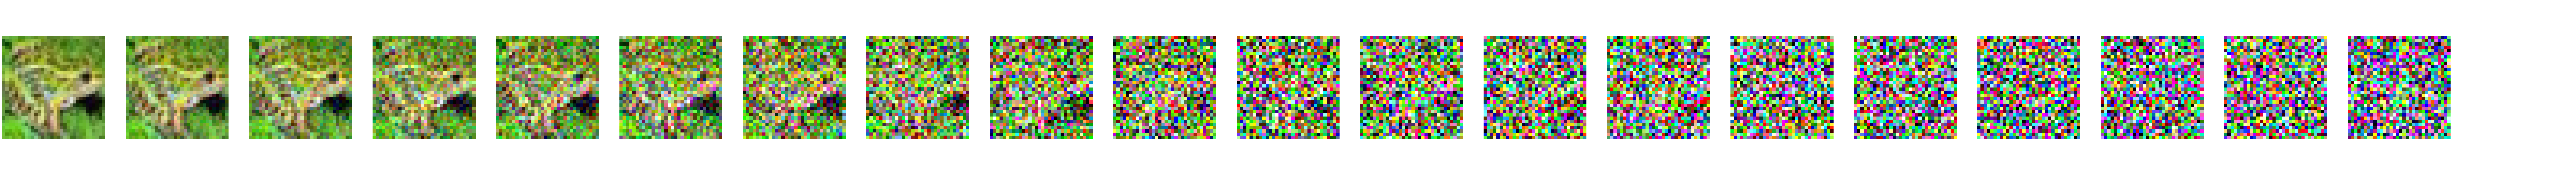

In [14]:
#Test the forward process through all t=0..t=T
with torch.no_grad():
    xT = next(iter(dataloader))[0][1]
    num_imgs = 20
    step = int(T/num_imgs)
    plt.figure(figsize=(150,10))
    plt.axis('off')
    for i in range(0,T,step):
        t = torch.tensor([i]).to(device)
        eps = torch.randn((1,3,32,32)).to(device)
        noisey = forward_process(xT.to(device),eps,t,sqrt_alphabar_prod,sqrtmin_alphabar)
        if i % step == 0:
            plt.subplot(1,num_imgs+1,int(i/step)+1)
            plot_image(noisey,True)
    plt.show()

In [15]:
steps = torch.linspace(0, 1000-1, 1000 + 1)

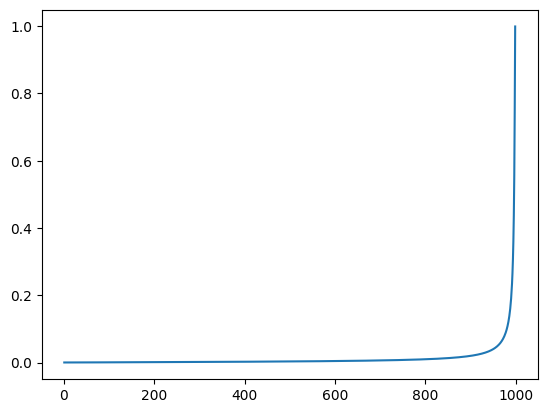

In [16]:
plt.plot(steps[1:].cpu(),beta.cpu())

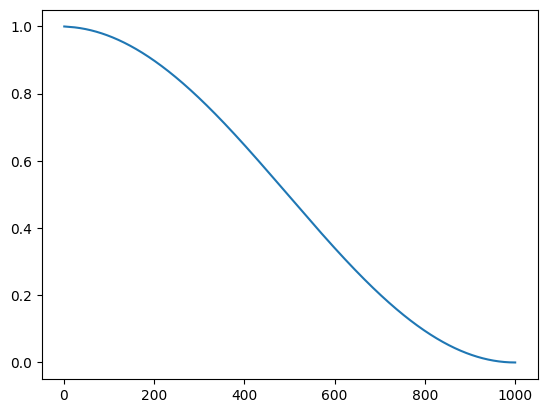

In [13]:
plt.plot(steps[1:].cpu(), alphabar.cpu())

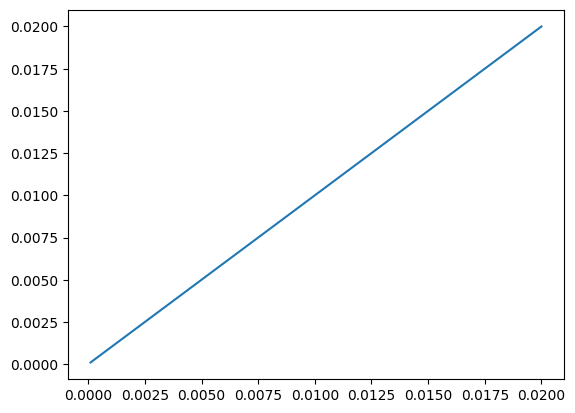

In [7]:
plt.plot(torch.linspace(0.0001,0.02,T),torch.linspace(0.0001,0.02,T))

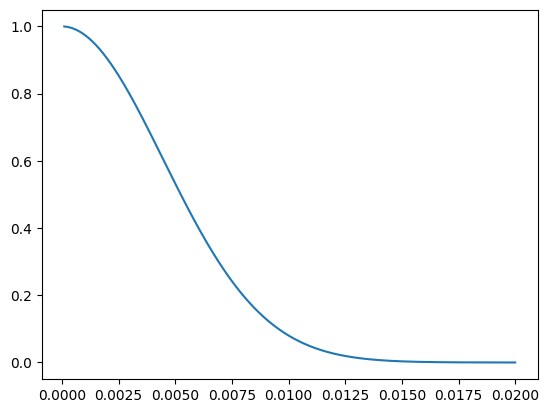

In [ ]:
plt.plot(torch.linspace(0.0001,0.02,T), alphabar.cpu())


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Parameters------------------------------------------------
LR = 2e-5
n_epochs = 100

In [7]:
#Define model and optimizer
network = UNet(image_channels=3,n_channels=64)
model = network.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
#Instead of training you can load in one of our own trained models
#OBS. make sure to have calculated the beta values for the same var. schedule as the model you loaded in
#Example of linear variance schedule CIFAR10 model:

#path = "./model_saved_linear"
#model.load_state_dict(torch.load(path,weights_only=True))


In [8]:
#Training loop
def training_loop(model, dataloader, optimizer, n_epochs, T, device):
    #model.train()
    for epoch in range(n_epochs):
        for s, b in enumerate(dataloader):
            t = torch.randint(0, T, (batch_size,)).long().to(device)
            optimizer.zero_grad()
            loss = get_loss(model,b[0].to(device),t,device,sqrt_alphabar_prod,sqrtmin_alphabar)
            loss.backward()
            optimizer.step()
            if epoch % 1 == 0 and s == 0:
                print(f"Epoch: {epoch}", f"step {s}", f"Loss: {loss.item()}")


In [24]:
training_loop(model, dataloader,optimizer,50,1000,device)

Epoch: 0 step 0 Loss: 0.07749008387327194
Epoch: 1 step 0 Loss: 0.058349452912807465
Epoch: 2 step 0 Loss: 0.06358268857002258
Epoch: 3 step 0 Loss: 0.06153842806816101
Epoch: 4 step 0 Loss: 0.0610453300178051
Epoch: 5 step 0 Loss: 0.059382759034633636
Epoch: 6 step 0 Loss: 0.06991443783044815
Epoch: 7 step 0 Loss: 0.05684549733996391
Epoch: 8 step 0 Loss: 0.05265238508582115
Epoch: 9 step 0 Loss: 0.0634860023856163
Epoch: 10 step 0 Loss: 0.07293910533189774
Epoch: 11 step 0 Loss: 0.05558081716299057
Epoch: 12 step 0 Loss: 0.06249610334634781
Epoch: 13 step 0 Loss: 0.04603598639369011
Epoch: 14 step 0 Loss: 0.05771808326244354
Epoch: 15 step 0 Loss: 0.056025903671979904
Epoch: 16 step 0 Loss: 0.05206122249364853
Epoch: 17 step 0 Loss: 0.06357063353061676
Epoch: 18 step 0 Loss: 0.05735035985708237
Epoch: 19 step 0 Loss: 0.061994343996047974
Epoch: 20 step 0 Loss: 0.07759794592857361
Epoch: 21 step 0 Loss: 0.060352325439453125
Epoch: 22 step 0 Loss: 0.06705224514007568
Epoch: 23 step 0 L

In [ ]:
#Save a trained model (saves a lot of time)

#torch.save(model.state_dict(), "model_cosine_cifar_full_real")

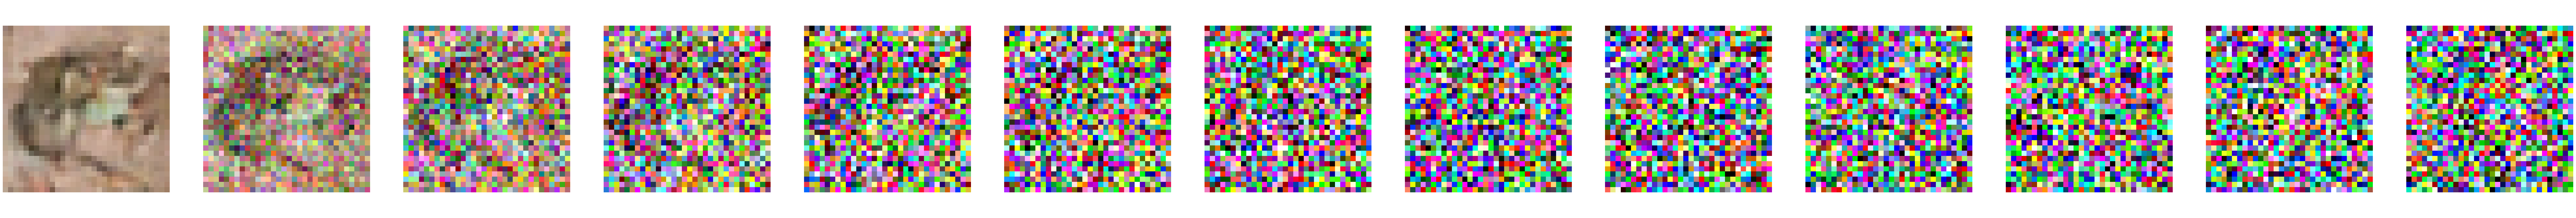

In [10]:
#Plot a sample
with torch.no_grad():
    xT = torch.randn((1,3,32,32)).to(device)
    #model.eval()
    num_imgs = 12
    step = int(T/num_imgs)
    plt.figure(figsize=(120,10))
    plt.axis('off')
    for i in range(0,T)[::-1]:
        t = torch.tensor([i]).to(device)
        eps_pred = model(xT,t)
        xT = backward_process(eps_pred,t,xT,alpha,beta,sqrtmin_alphabar,device)
        if i % step == 0:
            plt.subplot(1,num_imgs+1,int(i/step)+1)
            plot_image(xT,True)
    plt.show()

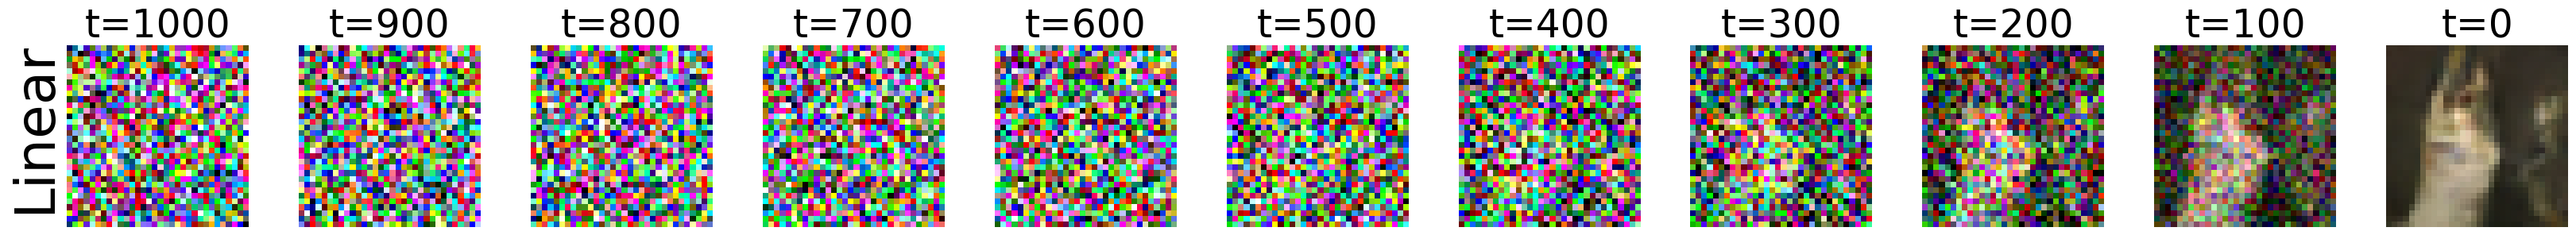

In [10]:
#Plot a sample for the report
with torch.no_grad():
    xT = torch.randn((1,3,32,32)).to(device)
    ft = xT
    model.eval()
    num_imgs = 11
    step = int(T/(num_imgs-1))
    #plt.figure(figsize=(120,10))
    fig, ax = plt.subplots(1, num_imgs, figsize=(3*num_imgs,3))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.1, hspace=0.2)
    #plt.axis('off')
    for i in range(0,T-20)[::-1]:
        t = torch.tensor([i]).to(device)
        eps_pred = model(xT,t)
        xT = backward_process(eps_pred,t,xT,alpha,beta,sqrtmin_alphabar,device)
        if i % step == 0:
            #fig, ax = plt.subplot(1,num_imgs+1,num_imgs-int(i/step)+1)
            img = torch.squeeze(xT)
            img = torch.clamp(img,-1.0,1.0)
            #print(images.shape)
            img = (img+1)/2
            ax[num_imgs-int(i/step)-1].imshow(img.detach().cpu().permute(1,2,0))
            ax[num_imgs-int(i/step)-1].axis('off')
            t_val = np.asanyarray(t.cpu())
            ax[num_imgs-int(i/step)-1].set_title(f"t={t_val[0]}",fontsize=35)
            #plot_image(xT,True)
    img = torch.squeeze(ft)
    img = torch.clamp(img,-1.0,1.0)
    #print(images.shape)
    img = (img+1)/2
    ax[0].imshow(img.detach().cpu().permute(1,2,0))
    ax[0].axis('off')
    ax[0].set_title(f"t={1000}",fontsize=35)
    ax[0].annotate("Linear", xy=(-0.03,0.55), xycoords='axes fraction', fontsize=50, ha='right', va='center', rotation=90)
    plt.tight_layout()
    plt.savefig("testcifar_linear.pdf", format="pdf",dpi=300)
    plt.show()

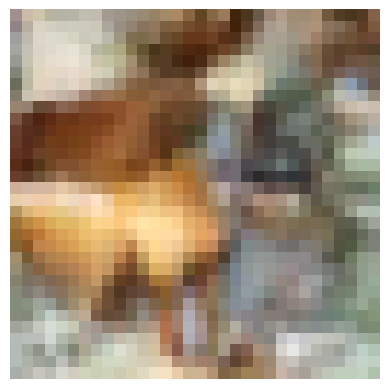

In [23]:
plot_image(xT,False)

In [40]:
#Sample many images at once
def sample_images(T,model,num_images):
    with torch.no_grad():
        imgs = []
        #model.eval()
        xT = torch.randn((num_images,3,32,32)).to(device)
        for i in range(0,T-20)[::-1]:
            t = torch.full((num_images,),i).long().to(device)
            eps_pred = model(xT,t)
            xT = backward_process(eps_pred,t[0],xT,alpha,beta,sqrtmin_alphabar,device)
        for j in range(num_images):
            imgs.append(xT[j])
        return imgs

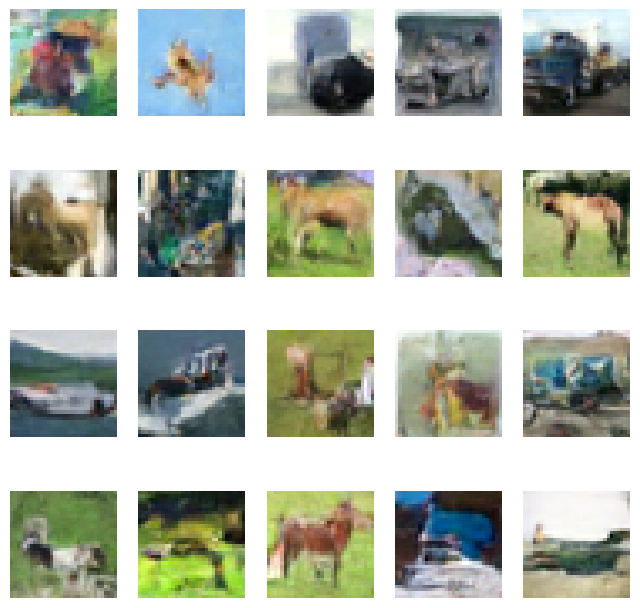

In [12]:
#Plot a grid of sampled images
images = sample_images(T,model, 20)
grid_plot(images) 

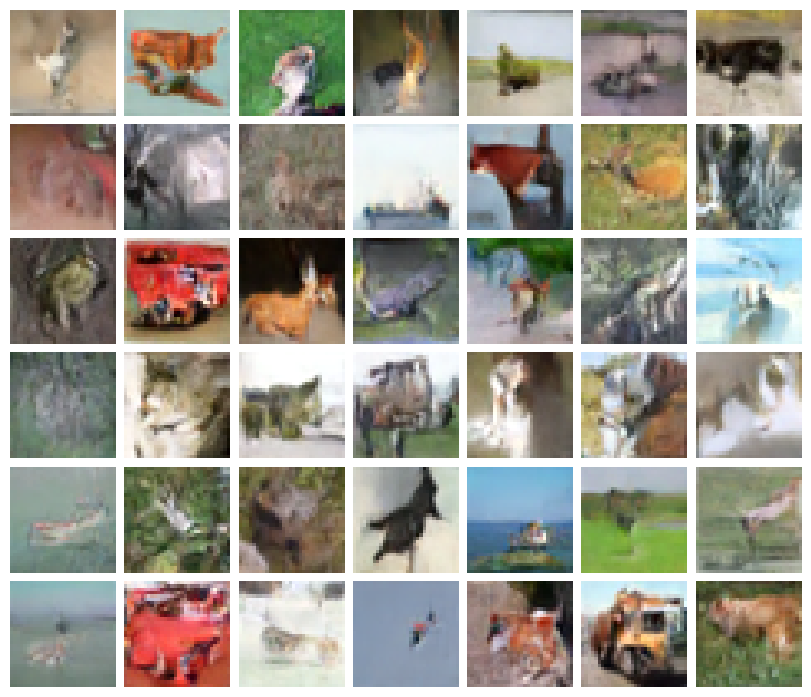

In [46]:
#Plot a grid for the report
images = sample_images(T,model,7*6)    
fig = plt.figure(figsize=(8,8), constrained_layout = True)
rows = int(7)
cols = 7
idx = 0
for r in range(rows):
    if r > 5:
        continue
    for c in range(cols):
        fig.add_subplot(rows,cols,idx+1)
        if idx < len(images):
            plot_image(images[idx], grid=True)
            idx +=1
fig.suptitle("", fontsize=30)
plt.show()